## Air Quality Dashboard
This notebook shows how to use IPython Widgets to display the air quality using Grove Sensors.

In [1]:
%matplotlib notebook
import matplotlib

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
import random
import threading
from IPython.display import display, clear_output
import time
import math
from redpitaya.overlay.mercury import mercury as FPGA

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from datetime import datetime, date
import pandas as pd

overlay = FPGA()
ANALOG_TEMP = FPGA.analog_in(1) # define which pin will be used for temperature sensor

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/lib/python3/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def res_to_temp(Rntc):
    B = 4275; # B value of the thermistor
    return (1.0/(math.log10(Rntc/100000.0)/B+1/298.15)-273.15) #convert to temperature via datasheet 
temp = [ res_to_temp(R) for R in range(10000,300000,100)]

def temp():
    Va0=ANALOG_TEMP.read() # read voltage of sensor
    R0 = 100000;       # R0 = 100k
    Rntc = 3.3/(Va0)-1.0 
    Rntc = 100000.0*Rntc # thermistor resistance
    return (res_to_temp(Rntc),Va0);
latest_temp=temp()

In [207]:
voc_air_pin = FPGA.analog_in(2) # define which pin will be used for VOC sensor
voc_air = voc_air_pin.read()
print(voc_air)

0.14037743455661325


In [3]:
voc_air = 0.140 #Refrence value with no voc
voc_volt = voc_air_pin.read()
voc_gas = voc_volt/(5.0)
voc_ratio = (voc_gas/voc_air)*3

In [32]:
ANALOG_Alcohol_pin = FPGA.analog_in(3) # define which pin will be used for alcohol sensor
Alcohol_air = ANALOG_Alcohol_pin.read()
print(Alcohol_air)

0.7583805305924349


In [193]:
ANALOG_Alcohol_pin = FPGA.analog_in(3) # define which pin will be used for alcohol sensor
Alcohol_volt = ANALOG_Alcohol_pin.read()
Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
#Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
Alcohol_ratio = (1/(Alcohol_gas/2.32))*2
print(Alcohol_volt,Alcohol_gas,Alcohol_ratio)

2.3025323107151805 0.8535903209745773 4.334632093503082


In [5]:
voc_bar = widgets.widgets.FloatProgress(
    value=voc_ratio,
    min=0,
    max=1.0,
    description='VOC Air:',
    bar_style='info',
    style={'bar_color': '#fcdb03'},
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
voc_label = widgets.FloatText(
    value=voc_bar.value,
#    description='Any:',
    disabled=True
)

temp_bar = widgets.widgets.FloatProgress(
    value=latest_temp[0],
    min=0,
    max=36.0,
    description='Temperature:',
    bar_style='info',
    style={'bar_color': '#4ba329'},
    orientation='horizontal'
)

temp_slider = widgets.FloatSlider(
    value=latest_temp[0],
    min=0,
    max=36.0,
    step=0.1,
    description='Test:',
    disabled=True,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
alcohol_bar = widgets.widgets.FloatProgress(
    value=Alcohol_ratio,
    min=0,
    max=36.0,
    description='Alcohol:',
    bar_style='info',
    style={'bar_color': '#69fffc'},
    orientation='horizontal'
)

alcohol_label = widgets.FloatText(
    value=Alcohol_ratio,
#    description='Any:',
    disabled=True
)

update_air_quality = True


def work(voc_bar):
    while update_air_quality == True:
        time.sleep(0.2)
        voc_volt = voc_air_pin.read()
        voc_gas = voc_volt/(5.0)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        voc_ratio = (voc_gas/voc_air)*3
        voc_bar.value = voc_ratio
        voc_label.value = voc_bar.value
        latest_temp=temp()[0]
        temp_bar.value = latest_temp
        temp_slider.value = latest_temp
        Alcohol_volt = ANALOG_Alcohol_pin.read()
        Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
        #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
        Alcohol_ratio = (1/(Alcohol_gas/1.85))*2
        
        alcohol_bar.value = Alcohol_ratio
        alcohol_label.value = Alcohol_ratio

thread = threading.Thread(target=work, args=(voc_bar,))
#display(progress)
#display(progress_label)
#display(temp_bar)
#display(temp_slider)
thread.start()

first_box = HBox([voc_bar, voc_label])
second_box = HBox([temp_bar, temp_slider])
third_box = HBox([alcohol_bar, alcohol_label])
VBox([first_box, second_box, third_box])

A Jupyter Widget

In [ ]:
threading.active_count()

In [6]:
update_air_quality = False

<IPython.core.display.Javascript object>


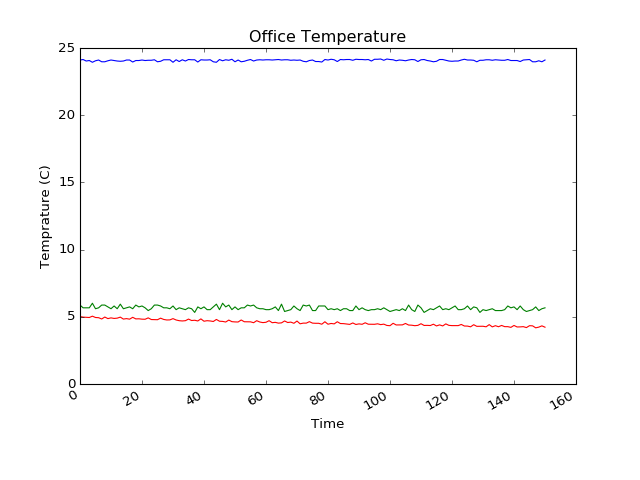

In [272]:
df = pd.DataFrame() #Create an empty data frame to append to later
#timestamp = df.size
def animate(i):
    global df
    clean_data_table = pd.DataFrame() #Create an empty data frame to append to later
    latest_temp=temp()[0]
    voc_volt = voc_air_pin.read()
    voc_gas = voc_volt/(5.0)
    #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
    voc_ratio = (voc_gas/voc_air)*28
    Alcohol_volt = ANALOG_Alcohol_pin.read()
    Alcohol_gas = Alcohol_volt/(5.0-Alcohol_volt)
    #Scale the result to be between 2.0 and 30.0 to keep on a similar scale to temperature
    Alcohol_ratio = (1/(Alcohol_gas/2.32))*1.5
    clear_output(wait=True)
    clean_data_table['Temperature (oC)'] = [latest_temp]
    clean_data_table['VOC in Air'] = [voc_ratio]
    clean_data_table['Alcohol in Air'] = [Alcohol_ratio]
#    clean_data_table['Date'] = [datetime.now()]
    timestamp = df.size
    timestamp = 2
    df = df.append(clean_data_table, ignore_index = True)
    df.index.name = 'timestamp'
    
    #x = df['Date']
    x = df.index
    y1 = df['Temperature (oC)']
    y2 = df['VOC in Air']
    y3 = df['Alcohol in Air']
    
    plt.cla()
    plt.plot(x,y1,label='Temperature (oC)')
    plt.plot(x,y2,label='VOC in Air')
    plt.plot(x,y3,label='Alcohol in Air')
    plt.xlabel('Time')
    plt.ylabel('Temprature (C)')
    plt.title("Office Temperature")
    plt.gcf().autofmt_xdate()
    plt.ticklabel_format(useOffset=False,axis='y')
#    plt.legend()
    plt.show()
    
ani = FuncAnimation(plt.gcf(), animate,interval=2000,save_count=850)
plt.show()

In [270]:
df.size

936

In [221]:
df.index.name = 'timestamp'
df

,Temperature (oC),VOC in Air,Alcohol in Air
timestamp,,,
0,24.086991,6.965854,17.695056


In [271]:
df.index.name = 'timestamp'
filename = "CSV-Data/Whiskey " + str(datetime.now()) + ".csv"
df.to_csv(filename)